## TEAM-11: 2D TO 3D - CYCLE GANs

In [2]:
import torch
torch.cuda.empty_cache()

In [3]:
import gc
gc.collect()

0

 ## Preprocessing and Data Loader

In [4]:
import os
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2
from PIL import Image
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import torch.nn as nn
from torch.optim import Adam
from tqdm import tqdm
import random
import torch.nn.init as init
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
def set_seed(seed):
    random.seed(seed)  
    np.random.seed(seed)  
    torch.manual_seed(seed)  
    torch.cuda.manual_seed(seed)  
    torch.cuda.manual_seed_all(seed)  
    torch.backends.cudnn.deterministic = True  
    torch.backends.cudnn.benchmark = False  

set_seed(42)

In [6]:
# paths
csv_file = '/projectnb/ec523kb/students/avantk/indiana_projections.csv'
image_folder = '/projectnb/ec523kb/students/avantk/images_png/'

In [7]:
data = pd.read_csv(csv_file)

# matching the images and their projection type
# adding the 'CXR' prefix to the UID and modifying the 'filename' column
data['filename'] = data['filename'].apply(lambda x: x.replace('.dcm', ''))  # remove .dcm from the filename
data['filename'] = data.apply(lambda row: f"CXR{row['filename']}", axis=1)  # Add 'CXR' before the UID


# saving the modified CSV file
modified_csv_file = "modified_csv_file.csv"  # Output CSV file
data.to_csv(modified_csv_file, index=False)

print(f"Modified CSV saved to: {modified_csv_file}")

Modified CSV saved to: modified_csv_file.csv


In [8]:
df = pd.read_csv('modified_csv_file.csv')
df.head(3)

,uid,filename,projection
0,1,CXR1_IM-0001-4001.png,Frontal
1,1,CXR1_IM-0001-3001.png,Lateral
2,2,CXR2_IM-0652-1001.png,Frontal


In [11]:
projection_counts = df['projection'].value_counts()

projection_counts

projection
Frontal    3818
Lateral    3648
Name: count, dtype: int64

In [12]:
def find_image_size_range(image_folder):
    min_width, min_height = float('inf'), float('inf')
    max_width, max_height = 0, 0
    
    for filename in os.listdir(image_folder):
        if filename.endswith(('png', 'jpg', 'jpeg')):  # Ensure it's an image
            file_path = os.path.join(image_folder, filename)
            try:
                with Image.open(file_path) as img:
                    width, height = img.size
                    min_width = min(min_width, width)
                    min_height = min(min_height, height)
                    max_width = max(max_width, width)
                    max_height = max(max_height, height)
            except Exception as e:
                print(f"Could not process {filename}: {e}")
    
    return {
        "min_size": (min_width, min_height),
        "max_size": (max_width, max_height)
    }

# Example usage
image_folder = '/projectnb/ec523kb/students/avantk/images_png/'  # Replace with your folder path
size_range = find_image_size_range(image_folder)

print(f"Minimum image size: {size_range['min_size']}")
print(f"Maximum image size: {size_range['max_size']}")


Minimum image size: (512, 362)
Maximum image size: (512, 873)


In [8]:
class CustomDataset:
    def __init__(self, csv_file, image_folder, transforms=None):
        self.data = pd.read_csv(csv_file)
        self.image_folder = image_folder
        self.transforms = transforms
        self.image_files = os.listdir(image_folder)

        # preprocessing data to filter entries based on occurrence count
        self.data = self.filter_data()

    def filter_data(self):
        # extracting CXR identifiers from filenames
        self.data['cxr_id'] = self.data['filename'].apply(lambda x: re.match(r'CXR\d+', x).group())

        # counting occurrences of each identifier
        cxr_counts = Counter(self.data['cxr_id'])

        # filtering out rows where cxr_id occurs only once or more than twice
        filtered_data = self.data[self.data['cxr_id'].map(cxr_counts).between(2, 2, inclusive="both")]

        # dropping the temporary column
        filtered_data = filtered_data.drop(columns=['cxr_id'])
        return filtered_data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # getting the row from the filtered .csv file
        row = self.data.iloc[idx]
        csv_filename = row['filename']
        projection = row['projection']

        # finding the image file that matches the CSV filename
        image_path = os.path.join(self.image_folder, csv_filename)
        if not os.path.exists(image_path):
            print(f"Image not found for {csv_filename}")
            return None

#         try:
#             image = Image.open(image_path)
#         except FileNotFoundError:
#             print(f"Image not found at {image_path}")
#             return None
        
        try:
            image = Image.open(image_path).convert("L")  
        except FileNotFoundError:
            print(f"Image not found at {image_path}")
            return None

        # applying transformations if any
        if self.transforms:
            image = self.transforms(image)

        return {'image_type': projection, 'image': image, 'filename': csv_filename}

In [9]:
# transforms
transforms = v2.Compose([
    v2.Resize((128, 128)),
    #v2.RandomHorizontalFlip(p=0.5),  
    v2.RandomRotation(degrees=10), 
    v2.ColorJitter(brightness=0.2, contrast=0.2),  
    v2.ToTensor(),
    v2.Normalize(mean=[0.0], std=[1.0]) 
])

csv_file = 'modified_csv_file.csv'

# loading dataset
dataset = CustomDataset(csv_file, image_folder, transforms)

/usr4/ec500/avantk/.local/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [10]:
# mapping frontal and lateral images based on their image IDs
frontal_mapping = {}
lateral_mapping = {}

# iterating through the dataset and populate mappings
for item in dataset:
    if item is not None:
        image_type = item['image_type']
        image = item['image']
        uid = int(item['filename'].split('_')[0][3:])  # extracting the UID from the filename

        if image_type == 'Frontal':
            frontal_mapping[uid] = image
        elif image_type == 'Lateral':
            lateral_mapping[uid] = image
        else:
            print('Unexpected type')

# extracting only the images that have both frontal and lateral biplanar views
frontal, lateral = [], []
for uid, lateral_image in lateral_mapping.items():
    if uid in frontal_mapping:
        frontal.append(frontal_mapping[uid])
        lateral.append(lateral_image)

print(f"Final counts -> Frontal: {len(frontal)}, Lateral: {len(lateral)}")

Image not found for CXR1_IM-0001-4001.png
Image not found for CXR1_IM-0001-3001.png
Final counts -> Frontal: 3193, Lateral: 3193


(128, 128, 1) (128, 128, 1)


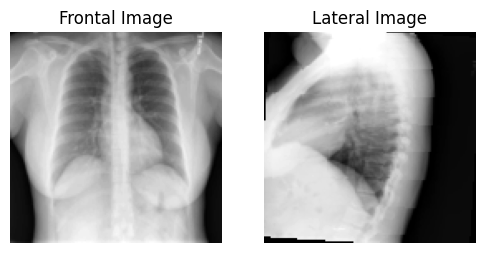

In [11]:
frontal_image = frontal[10]
lateral_image = lateral[10]

frontal_image = frontal_image.permute(1, 2, 0).numpy()  # Change to (H, W, C)
lateral_image = lateral_image.permute(1, 2, 0).numpy()  # Change to (H, W, C)
print(frontal_image.shape, lateral_image.shape)


# plotting the images side by side
plt.figure(figsize=(6, 3))

# frontal image
plt.subplot(1, 2, 1)
plt.imshow(frontal_image, cmap='gray')
plt.title("Frontal Image")
plt.axis('off')

# lateral image
plt.subplot(1, 2, 2)
plt.imshow(lateral_image, cmap='gray')
plt.title("Lateral Image")
plt.axis('off')


plt.show()

In [12]:
class PairedXRayDataset(Dataset):
    def __init__(self, frontal_images, lateral_images):
        self.frontal_images = frontal_images
        self.lateral_images = lateral_images
        
    def __len__(self):
        return len(self.frontal_images)
    
    def __getitem__(self, idx):
        frontal_image = self.frontal_images[idx]
        lateral_image = self.lateral_images[idx]
        
        return {'frontal': frontal_image, 'lateral': lateral_image}

In [13]:
from torch.utils.data import random_split, DataLoader

# forming the dataset
paired_dataset = PairedXRayDataset(frontal, lateral)

dataset_size = len(paired_dataset)

# defining train-test split sizes
train_size = int(0.9 * dataset_size)  # 90% for training
test_size = dataset_size - train_size  # 10% for testing

# performing the split
train_dataset, test_dataset = random_split(paired_dataset, [train_size, test_size])

# creating dataLoaders for train and test sets
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# verifying the splits
print(f"Training samples: {len(train_loader.dataset)}")
print(f"Testing samples: {len(test_loader.dataset)}")

Training samples: 2873
Testing samples: 320


In [14]:
# checking train DataLoader
for batch in train_loader:
    frontal_batch = batch['frontal']
    lateral_batch = batch['lateral']
    print(f"Train - Frontal batch shape: {frontal_batch.shape}")
    print(f"Train - Lateral batch shape: {lateral_batch.shape}")
    break

# checking test DataLoader
for batch in test_loader:
    frontal_batch = batch['frontal']
    lateral_batch = batch['lateral']
    print(f"Test - Frontal batch shape: {frontal_batch.shape}")
    print(f"Test - Lateral batch shape: {lateral_batch.shape}")
    break

Train - Frontal batch shape: torch.Size([16, 1, 128, 128])
Train - Lateral batch shape: torch.Size([16, 1, 128, 128])
Test - Frontal batch shape: torch.Size([16, 1, 128, 128])
Test - Lateral batch shape: torch.Size([16, 1, 128, 128])


## GAN - GENERATOR AND DISCRIMINATOR

## CYCLEGAN - BIPLANAR IMAGES - LAMBDA 15

In [16]:
# 3D residual block
class ResidualBlock3D(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock3D, self).__init__()
        self.block = nn.Sequential(
            nn.Conv3d(channels, channels, kernel_size=3, stride=1, padding=1),
            nn.InstanceNorm3d(channels),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.3),
            nn.Conv3d(channels, channels, kernel_size=3, stride=1, padding=1),
            nn.InstanceNorm3d(channels)
        )

    def forward(self, x):
        return x + self.block(x)

class CycleGANGenerator3D(nn.Module):
    def __init__(self, input_channels=2, output_channels=1, num_residual_blocks=6, target_depth=64):
        super(CycleGANGenerator3D, self).__init__()
        self.target_depth = target_depth

        # initial Convolution Block
        self.initial = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=7, stride=1, padding=3),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.3)
        )

        # downsampling Layers
        self.downsampling = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # (64, 64) -> (32, 32)
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),  # (32, 32) -> (16, 16)
            nn.InstanceNorm2d(256),
            nn.ReLU(inplace=True)
        )

        # reshaping to 3D
        self.reshape_to_3d = nn.Conv3d(256, 256, kernel_size=(1, 1, 1))

        # residual Blocks
        self.residual_blocks = nn.Sequential(
            *[ResidualBlock3D(256) for _ in range(num_residual_blocks)]
        )

        # upsampling Layers
        self.upsampling = nn.Sequential(
            nn.ConvTranspose3d(256, 128, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1), output_padding=(0, 0, 0)),  # (16, 16, 16) -> (32, 32, 32)
            nn.InstanceNorm3d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.3),
            nn.ConvTranspose3d(128, 64, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1), output_padding=(0, 0, 0)),  # (32, 32, 32) -> (64, 64, 64)
            nn.InstanceNorm3d(64),
            nn.ReLU(inplace=True)
        )

        # output Layer
        self.output_layer = nn.Sequential(
            nn.Conv3d(64, output_channels, kernel_size=7, stride=1, padding=3),
            nn.Tanh()
        )

    def forward(self, x):
        # process 2D input
        x = self.initial(x)

        x = self.downsampling(x)

        # reshape to add a depth dimension
        x = x.unsqueeze(2)  

        x = self.reshape_to_3d(x)

        x = self.residual_blocks(x)

        x = self.upsampling(x)

        # resize to final 3D volume
        x = nn.functional.interpolate(x, size=(self.target_depth, 64, 64), mode='trilinear', align_corners=True)

        return self.output_layer(x)

# instantiating the generator for 64x64 inputs and 64x64x64 outputs
generator_3d = CycleGANGenerator3D(input_channels=2, output_channels=1, target_depth=64)

# TESTING GENERATOR with a dummy input of size 64x64
dummy_input_2d = torch.randn(1, 2, 64, 64)  # batch size 1
output_3d = generator_3d(dummy_input_2d)
print(f"Input shape: {dummy_input_2d.shape}")
print(f"Output shape: {output_3d.shape}")


Input shape: torch.Size([1, 2, 64, 64])
Output shape: torch.Size([1, 1, 64, 64, 64])


In [17]:
class Generator3DTo2D(nn.Module):
    def __init__(self, input_channels=1, output_channels=2):
        super(Generator3DTo2D, self).__init__()

        self.feature_extraction = nn.Sequential(
            nn.Conv3d(input_channels, 64, kernel_size=4, stride=2, padding=1),  # (64, 64, 64) -> (32, 32, 32)
            nn.InstanceNorm3d(64),
            nn.ReLU(inplace=True),

            nn.Conv3d(64, 128, kernel_size=4, stride=2, padding=1),  # (32, 32, 32) -> (16, 16, 16)
            nn.InstanceNorm3d(128),
            nn.ReLU(inplace=True),

            nn.Conv3d(128, 256, kernel_size=4, stride=2, padding=1),  # (16, 16, 16) -> (8, 8, 8)
            nn.InstanceNorm3d(256),
            nn.ReLU(inplace=True),
        )

        self.output_channels = output_channels

        # upsampling layer to restore spatial dimensions to 64x64
        self.upsample = nn.Upsample(scale_factor=8, mode="bilinear", align_corners=True)

    def forward(self, x):
        # Feature extraction
        x = self.feature_extraction(x)
        #print(f"Shape after feature extraction: {x.shape}")  # Debugging shape

        # Flatten the 3D volume into 2D
        batch_size, channels, depth, height, width = x.shape
        x = x.view(batch_size, channels * depth, height, width)  # Merge depth into channels

        # Reduce to the desired number of output channels
        final_conv = nn.Conv2d(
            in_channels=channels * depth, out_channels=self.output_channels,
            kernel_size=1, stride=1, padding=0
        ).to(x.device)  # Ensure it's on the correct device

        x = final_conv(x)  # Final shape before upsampling: [batch_size, output_channels, height, width]

        # Upsample to original dimensions
        x = self.upsample(x)  # Final shape: [batch_size, output_channels, 64, 64]
        return x

# Test Generator B with Dummy Input
dummy_input_3d = torch.randn(1, 1, 64, 64, 64).to("cuda")
generator_3d_to_2d = Generator3DTo2D(input_channels=1, output_channels=2).to("cuda")
output_2d = generator_3d_to_2d(dummy_input_3d)
print(f"Input shape (3D): {dummy_input_3d.shape}")
print(f"Output shape (2D): {output_2d.shape}")


Input shape (3D): torch.Size([1, 1, 64, 64, 64])
Output shape (2D): torch.Size([1, 2, 64, 64])


In [18]:
class PatchGANDiscriminator3D(nn.Module):
    def __init__(self, input_channels=1):
        super(PatchGANDiscriminator3D, self).__init__()
        
        # Convolutional layers
        self.model = nn.Sequential(
            nn.Conv3d(input_channels, 64, kernel_size=4, stride=2, padding=1),  # (64 -> 32)
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv3d(64, 128, kernel_size=4, stride=2, padding=1),  # (32 -> 16)
            nn.InstanceNorm3d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(p=0.3),
            
            nn.Conv3d(128, 256, kernel_size=4, stride=2, padding=1),  # (16 -> 8)
            nn.InstanceNorm3d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(p=0.3),
            
            nn.Conv3d(256, 512, kernel_size=4, stride=2, padding=1),  # (8 -> 4)
            nn.InstanceNorm3d(512),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv3d(512, 1, kernel_size=3, stride=1, padding=0)  # (4 -> 2)
        )

    def forward(self, x):
        return self.model(x)

# instantiating the discriminator
discriminator_3d = PatchGANDiscriminator3D(input_channels=1)

# TESTING THE DISCRIMINATOR with a dummy input of size 64x64x64
dummy_input_3d = torch.randn(1, 1, 64, 64, 64)  # Batch size of 1
output = discriminator_3d(dummy_input_3d)
print(f"Input shape: {dummy_input_3d.shape}")
print(f"Output shape: {output.shape}")


Input shape: torch.Size([1, 1, 64, 64, 64])
Output shape: torch.Size([1, 1, 2, 2, 2])


In [19]:
# loss functions
adversarial_loss = nn.BCEWithLogitsLoss()  
cycle_consistency_loss = nn.L1Loss()  # for reconstruction consistency

# optimizers
lr = 1e-5
beta1, beta2 = 0.5, 0.999

optimizer_G = Adam(generator_3d.parameters(), lr=lr, betas=(beta1, beta2))
optimizer_D = Adam(discriminator_3d.parameters(), lr=lr, betas=(beta1, beta2))

# moving to device
generator_3d.to(device)
discriminator_3d.to(device)

PatchGANDiscriminator3D(
  (model): Sequential(
    (0): Conv3d(1, 64, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv3d(64, 128, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
    (3): InstanceNorm3d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Dropout(p=0.3, inplace=False)
    (6): Conv3d(128, 256, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
    (7): InstanceNorm3d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Dropout(p=0.3, inplace=False)
    (10): Conv3d(256, 512, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
    (11): InstanceNorm3d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (12): LeakyReLU(negative_slope=0.2, inplace=True)
    (13): Conv3d(512, 1, kernel_si

In [21]:
# instantiating generators 
input_channels_2d = 2  # 1 for frontal + 1 for lateral
input_channels_3d = 1  
output_channels_2d = 2  # 1 channel each for frontal and lateral
output_channels_3d = 1  

generator_2d_to_3d = CycleGANGenerator3D(input_channels=input_channels_2d, output_channels=output_channels_3d).to(device)
generator_3d_to_2d = Generator3DTo2D(input_channels=input_channels_3d, output_channels=output_channels_2d).to(device)

# optimizers
optimizer_G_A = Adam(generator_2d_to_3d.parameters(), lr=1e-5, betas=(0.5, 0.999))
optimizer_G_B = Adam(generator_3d_to_2d.parameters(), lr=1e-5, betas=(0.5, 0.999))


In [22]:
# weight initialization
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.Conv3d, nn.ConvTranspose3d)):
            init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='leaky_relu')
        elif isinstance(m, (nn.InstanceNorm2d, nn.InstanceNorm3d)) and m.weight is not None:
            init.constant_(m.weight, 1)
            init.constant_(m.bias, 0)

# initializing weights
initialize_weights(generator_2d_to_3d)
initialize_weights(generator_3d_to_2d)
initialize_weights(discriminator_3d)

In [39]:
# TRAINING LOOP

# lists to track losses for plotting
losses = {
    "G_A": [],           # generator A adversarial loss
    "Cycle_A": [],       # cycle consistency loss A (2D->3D->2D)
    "Cycle_B": [],       # cycle consistency loss B (3D->2D->3D)
    "D": []              # discriminator loss
}

num_epochs = 40
lambda_cycle = 15
adversarial_loss = nn.BCEWithLogitsLoss()
cycle_consistency_loss = nn.L1Loss()
label_smoothing = 0.1

for epoch in range(num_epochs):
    generator_2d_to_3d.train()
    generator_3d_to_2d.train()
    discriminator_3d.train()

    epoch_loss_G_A = 0.0
    epoch_loss_Cycle_A = 0.0
    epoch_loss_Cycle_B = 0.0
    epoch_loss_D = 0.0

    for i, batch in enumerate(tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]")):
        frontal, lateral = batch['frontal'].to(device), batch['lateral'].to(device)
        input_xrays = torch.cat((frontal, lateral), dim=1)

        # -------------------
        # Train Generator A (2D to 3D)
        # -------------------
        optimizer_G_A.zero_grad()
        fake_3d = generator_2d_to_3d(input_xrays)
        real_labels = (1.0 - label_smoothing) * torch.ones_like(discriminator_3d(fake_3d)).to(device)
        loss_G_A_adv = adversarial_loss(discriminator_3d(fake_3d), real_labels)

        # Train Generator B (3D to 2D)
        optimizer_G_B.zero_grad()
        reconstructed_xrays = generator_3d_to_2d(fake_3d)
        loss_cycle_A = cycle_consistency_loss(reconstructed_xrays, input_xrays)

        reconstructed_volumes = generator_2d_to_3d(reconstructed_xrays)
        loss_cycle_B = cycle_consistency_loss(reconstructed_volumes, fake_3d)

        loss_G = loss_G_A_adv + lambda_cycle * (loss_cycle_A + loss_cycle_B)
        loss_G.backward()

        # gradient clipping for the generators
        torch.nn.utils.clip_grad_norm_(generator_2d_to_3d.parameters(), max_norm=1.0)
        torch.nn.utils.clip_grad_norm_(generator_3d_to_2d.parameters(), max_norm=1.0)

        optimizer_G_A.step()
        optimizer_G_B.step()

        # -------------------
        # Train Discriminator (3D)
        # -------------------
        if i % 2 == 0:  # balancing training steps
            optimizer_D.zero_grad()
            real_3d = torch.randn_like(fake_3d).to(device)
            real_scores = discriminator_3d(real_3d)
            real_labels = (1.0 - label_smoothing) * torch.ones_like(real_scores).to(device)
            loss_real = adversarial_loss(real_scores, real_labels)

            fake_scores = discriminator_3d(fake_3d.detach())
            fake_labels = label_smoothing * torch.zeros_like(fake_scores).to(device)
            loss_fake = adversarial_loss(fake_scores, fake_labels)

            loss_D = (loss_real + loss_fake) / 2
            loss_D.backward()

            # gradient clipping for the discriminator
            torch.nn.utils.clip_grad_norm_(discriminator_3d.parameters(), max_norm=1.0)

            optimizer_D.step()

        # accumulating losses
        epoch_loss_G_A += loss_G_A_adv.item()
        epoch_loss_Cycle_A += loss_cycle_A.item()
        epoch_loss_Cycle_B += loss_cycle_B.item()
        epoch_loss_D += loss_D.item() if i % 2 == 0 else 0.0

    # average losses
    avg_loss_G_A = epoch_loss_G_A / len(train_loader)
    avg_loss_Cycle_A = epoch_loss_Cycle_A / len(train_loader)
    avg_loss_Cycle_B = epoch_loss_Cycle_B / len(train_loader)
    avg_loss_D = epoch_loss_D / (len(train_loader) / 2)

    # appending epoch losses to the dictionary
    losses["G_A"].append(avg_loss_G_A)
    losses["Cycle_A"].append(avg_loss_Cycle_A)
    losses["Cycle_B"].append(avg_loss_Cycle_B)
    losses["D"].append(avg_loss_D)

    print(
        f"Epoch [{epoch+1}/{num_epochs}] Training: "
        f"Loss_G_A: {avg_loss_G_A:.4f} | "
        f"Loss_Cycle_A: {avg_loss_Cycle_A:.4f} | "
        f"Loss_Cycle_B: {avg_loss_Cycle_B:.4f} | "
        f"Loss_D: {avg_loss_D:.4f}"
    )

    # saving checkpoints every 10 epochs
    if (epoch + 1) % 20 == 0:
        torch.save(generator_2d_to_3d.state_dict(), f"generator_2d_to_3d_epoch_{epoch+1}.pth")
        torch.save(generator_3d_to_2d.state_dict(), f"generator_3d_to_2d_epoch_{epoch+1}.pth")
        torch.save(discriminator_3d.state_dict(), f"discriminator_epoch_{epoch+1}.pth")


Epoch [1/40]: 100%|██████████| 180/180 [06:55<00:00,  2.31s/it]


Epoch [1/40] Training: Loss_G_A: 5.3953 | Loss_Cycle_A: 0.4942 | Loss_Cycle_B: 0.0317 | Loss_D: 0.2337


Epoch [2/40]: 100%|██████████| 180/180 [06:55<00:00,  2.31s/it]


Epoch [2/40] Training: Loss_G_A: 7.3488 | Loss_Cycle_A: 0.4835 | Loss_Cycle_B: 0.0001 | Loss_D: 0.1821


Epoch [3/40]: 100%|██████████| 180/180 [06:55<00:00,  2.31s/it]


Epoch [3/40] Training: Loss_G_A: 7.7666 | Loss_Cycle_A: 0.4741 | Loss_Cycle_B: 0.0000 | Loss_D: 0.1811


Epoch [4/40]: 100%|██████████| 180/180 [06:55<00:00,  2.31s/it]


Epoch [4/40] Training: Loss_G_A: 7.9899 | Loss_Cycle_A: 0.4705 | Loss_Cycle_B: 0.0000 | Loss_D: 0.1794


Epoch [5/40]: 100%|██████████| 180/180 [06:54<00:00,  2.30s/it]


Epoch [5/40] Training: Loss_G_A: 8.1377 | Loss_Cycle_A: 0.4634 | Loss_Cycle_B: 0.0000 | Loss_D: 0.1788


Epoch [6/40]: 100%|██████████| 180/180 [06:55<00:00,  2.31s/it]


Epoch [6/40] Training: Loss_G_A: 7.1502 | Loss_Cycle_A: 0.4749 | Loss_Cycle_B: 0.0212 | Loss_D: 0.1793


Epoch [7/40]: 100%|██████████| 180/180 [06:55<00:00,  2.31s/it]


Epoch [7/40] Training: Loss_G_A: 5.5775 | Loss_Cycle_A: 0.5099 | Loss_Cycle_B: 0.0615 | Loss_D: 0.1788


Epoch [8/40]: 100%|██████████| 180/180 [06:55<00:00,  2.31s/it]


Epoch [8/40] Training: Loss_G_A: 6.4591 | Loss_Cycle_A: 0.5056 | Loss_Cycle_B: 0.0463 | Loss_D: 0.1777


Epoch [9/40]: 100%|██████████| 180/180 [06:55<00:00,  2.31s/it]


Epoch [9/40] Training: Loss_G_A: 6.8291 | Loss_Cycle_A: 0.5029 | Loss_Cycle_B: 0.0400 | Loss_D: 0.1761


Epoch [10/40]: 100%|██████████| 180/180 [06:55<00:00,  2.31s/it]


Epoch [10/40] Training: Loss_G_A: 7.1977 | Loss_Cycle_A: 0.4984 | Loss_Cycle_B: 0.0315 | Loss_D: 0.1754


Epoch [11/40]: 100%|██████████| 180/180 [06:55<00:00,  2.31s/it]


Epoch [11/40] Training: Loss_G_A: 7.2946 | Loss_Cycle_A: 0.4987 | Loss_Cycle_B: 0.0283 | Loss_D: 0.1749


Epoch [12/40]: 100%|██████████| 180/180 [06:55<00:00,  2.31s/it]


Epoch [12/40] Training: Loss_G_A: 7.3716 | Loss_Cycle_A: 0.4815 | Loss_Cycle_B: 0.0257 | Loss_D: 0.1743


Epoch [13/40]: 100%|██████████| 180/180 [06:55<00:00,  2.31s/it]


Epoch [13/40] Training: Loss_G_A: 7.4597 | Loss_Cycle_A: 0.4885 | Loss_Cycle_B: 0.0246 | Loss_D: 0.1735


Epoch [14/40]: 100%|██████████| 180/180 [06:55<00:00,  2.31s/it]


Epoch [14/40] Training: Loss_G_A: 7.4478 | Loss_Cycle_A: 0.4845 | Loss_Cycle_B: 0.0258 | Loss_D: 0.1729


Epoch [15/40]: 100%|██████████| 180/180 [06:55<00:00,  2.31s/it]


Epoch [15/40] Training: Loss_G_A: 7.4628 | Loss_Cycle_A: 0.4846 | Loss_Cycle_B: 0.0253 | Loss_D: 0.1723


Epoch [16/40]: 100%|██████████| 180/180 [06:55<00:00,  2.31s/it]


Epoch [16/40] Training: Loss_G_A: 7.5186 | Loss_Cycle_A: 0.4809 | Loss_Cycle_B: 0.0242 | Loss_D: 0.1718


Epoch [17/40]: 100%|██████████| 180/180 [06:55<00:00,  2.31s/it]


Epoch [17/40] Training: Loss_G_A: 7.6057 | Loss_Cycle_A: 0.4758 | Loss_Cycle_B: 0.0237 | Loss_D: 0.1714


Epoch [18/40]: 100%|██████████| 180/180 [06:55<00:00,  2.31s/it]


Epoch [18/40] Training: Loss_G_A: 7.7778 | Loss_Cycle_A: 0.4740 | Loss_Cycle_B: 0.0227 | Loss_D: 0.1712


Epoch [19/40]: 100%|██████████| 180/180 [06:55<00:00,  2.31s/it]


Epoch [19/40] Training: Loss_G_A: 7.8919 | Loss_Cycle_A: 0.4755 | Loss_Cycle_B: 0.0218 | Loss_D: 0.1701


Epoch [20/40]: 100%|██████████| 180/180 [06:55<00:00,  2.31s/it]


Epoch [20/40] Training: Loss_G_A: 8.0211 | Loss_Cycle_A: 0.4664 | Loss_Cycle_B: 0.0207 | Loss_D: 0.1700


Epoch [21/40]: 100%|██████████| 180/180 [06:54<00:00,  2.31s/it]


Epoch [21/40] Training: Loss_G_A: 8.1123 | Loss_Cycle_A: 0.4749 | Loss_Cycle_B: 0.0198 | Loss_D: 0.1698


Epoch [22/40]: 100%|██████████| 180/180 [06:54<00:00,  2.31s/it]


Epoch [22/40] Training: Loss_G_A: 6.6751 | Loss_Cycle_A: 0.4781 | Loss_Cycle_B: 0.0320 | Loss_D: 0.1708


Epoch [23/40]: 100%|██████████| 180/180 [06:54<00:00,  2.31s/it]


Epoch [23/40] Training: Loss_G_A: 6.3782 | Loss_Cycle_A: 0.4848 | Loss_Cycle_B: 0.0330 | Loss_D: 0.1698


Epoch [24/40]: 100%|██████████| 180/180 [06:54<00:00,  2.31s/it]


Epoch [24/40] Training: Loss_G_A: 5.6858 | Loss_Cycle_A: 0.4882 | Loss_Cycle_B: 0.0513 | Loss_D: 0.1776


Epoch [25/40]: 100%|██████████| 180/180 [06:54<00:00,  2.30s/it]


Epoch [25/40] Training: Loss_G_A: 5.2760 | Loss_Cycle_A: 0.4929 | Loss_Cycle_B: 0.0333 | Loss_D: 0.1726


Epoch [26/40]: 100%|██████████| 180/180 [06:54<00:00,  2.30s/it]


Epoch [26/40] Training: Loss_G_A: 6.6990 | Loss_Cycle_A: 0.4859 | Loss_Cycle_B: 0.0316 | Loss_D: 0.1706


Epoch [27/40]: 100%|██████████| 180/180 [06:54<00:00,  2.30s/it]


Epoch [27/40] Training: Loss_G_A: 7.5521 | Loss_Cycle_A: 0.4839 | Loss_Cycle_B: 0.0278 | Loss_D: 0.1695


Epoch [28/40]: 100%|██████████| 180/180 [06:54<00:00,  2.30s/it]


Epoch [28/40] Training: Loss_G_A: 7.8203 | Loss_Cycle_A: 0.4774 | Loss_Cycle_B: 0.0249 | Loss_D: 0.1689


Epoch [29/40]: 100%|██████████| 180/180 [06:54<00:00,  2.30s/it]


Epoch [29/40] Training: Loss_G_A: 8.0429 | Loss_Cycle_A: 0.4725 | Loss_Cycle_B: 0.0233 | Loss_D: 0.1685


Epoch [30/40]: 100%|██████████| 180/180 [06:54<00:00,  2.30s/it]


Epoch [30/40] Training: Loss_G_A: 8.1769 | Loss_Cycle_A: 0.4767 | Loss_Cycle_B: 0.0219 | Loss_D: 0.1682


Epoch [31/40]: 100%|██████████| 180/180 [06:54<00:00,  2.30s/it]


Epoch [31/40] Training: Loss_G_A: 8.3064 | Loss_Cycle_A: 0.4766 | Loss_Cycle_B: 0.0209 | Loss_D: 0.1677


Epoch [32/40]: 100%|██████████| 180/180 [06:54<00:00,  2.30s/it]


Epoch [32/40] Training: Loss_G_A: 8.3275 | Loss_Cycle_A: 0.4720 | Loss_Cycle_B: 0.0217 | Loss_D: 0.1674


Epoch [33/40]: 100%|██████████| 180/180 [06:54<00:00,  2.30s/it]


Epoch [33/40] Training: Loss_G_A: 7.2518 | Loss_Cycle_A: 0.4711 | Loss_Cycle_B: 0.0378 | Loss_D: 0.1685


Epoch [34/40]: 100%|██████████| 180/180 [06:54<00:00,  2.30s/it]


Epoch [34/40] Training: Loss_G_A: 6.3382 | Loss_Cycle_A: 0.4725 | Loss_Cycle_B: 0.0683 | Loss_D: 0.1680


Epoch [35/40]: 100%|██████████| 180/180 [06:54<00:00,  2.30s/it]


Epoch [35/40] Training: Loss_G_A: 6.8520 | Loss_Cycle_A: 0.4790 | Loss_Cycle_B: 0.0584 | Loss_D: 0.1673


Epoch [36/40]: 100%|██████████| 180/180 [06:54<00:00,  2.30s/it]


Epoch [36/40] Training: Loss_G_A: 7.2207 | Loss_Cycle_A: 0.4742 | Loss_Cycle_B: 0.0540 | Loss_D: 0.1670


Epoch [37/40]: 100%|██████████| 180/180 [06:54<00:00,  2.30s/it]


Epoch [37/40] Training: Loss_G_A: 7.5154 | Loss_Cycle_A: 0.4765 | Loss_Cycle_B: 0.0502 | Loss_D: 0.1666


Epoch [38/40]:  46%|████▌     | 83/180 [03:13<03:46,  2.34s/it]


KeyboardInterrupt: 

In [47]:
# EVALUATION LOOP

from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import numpy as np

def evaluate_model(test_loader, generator_2d_to_3d, generator_3d_to_2d, device):
    generator_2d_to_3d.eval()
    generator_3d_to_2d.eval()

    total_ssim = 0.0
    total_psnr = 0.0
    num_samples = 0

    with torch.no_grad():
        for batch in test_loader:
            frontal, lateral = batch['frontal'].to(device), batch['lateral'].to(device)
            input_xrays = torch.cat((frontal, lateral), dim=1)  # combined input with 2 channels

            # generating 3D and reconstructing 2D (cycle)
            fake_3d = generator_2d_to_3d(input_xrays)
            reconstructed_xrays = generator_3d_to_2d(fake_3d)

            # looping over batch
            for i in range(reconstructed_xrays.size(0)):
                reconstructed = reconstructed_xrays[i].cpu().numpy()
                original = input_xrays[i].cpu().numpy()

                # processing channels separately
                for c in range(reconstructed.shape[0]):  # Loop over 2 channels
                    reconstructed_channel = np.clip(reconstructed[c], 0, 1)
                    original_channel = np.clip(original[c], 0, 1)

                    # computing metrics for the channel
                    total_ssim += ssim(reconstructed_channel, original_channel, data_range=1.0, win_size=3)
                    total_psnr += psnr(reconstructed_channel, original_channel, data_range=1.0)
                    num_samples += 1

    # average 
    avg_ssim = total_ssim / num_samples if num_samples > 0 else 0
    avg_psnr = total_psnr / num_samples if num_samples > 0 else 0
    print(f"Average SSIM: {avg_ssim:.4f}")
    print(f"Average PSNR: {avg_psnr:.4f}")

    return avg_ssim, avg_psnr

# evaluating the model
avg_ssim, avg_psnr = evaluate_model(test_loader, generator_2d_to_3d, generator_3d_to_2d, device)


Average SSIM: 0.2590
Average PSNR: 11.2179


In [41]:
losses

{'G_A': [5.395305362343788,
  7.348821830749512,
  7.766608863406711,
  7.989891261524624,
  8.137742100821601,
  7.150198421213362,
  5.5775288661321,
  6.459099896748861,
  6.82906452814738,
  7.197678181860182,
  7.294581935140822,
  7.371590852737427,
  7.459664943483141,
  7.447839339574178,
  7.462816972202725,
  7.518606474664476,
  7.605677156978183,
  7.77778476079305,
  7.891857976383633,
  8.021100907855564,
  8.112337848875258,
  6.675059549013773,
  6.3782045735253226,
  5.685761810673608,
  5.275965921084086,
  6.698975708749559,
  7.552115098635356,
  7.820345062679714,
  8.042904535929361,
  8.17687536875407,
  8.306444141599867,
  8.327547947565714,
  7.251792653401693,
  6.338212301996019,
  6.852022873030768,
  7.220691892835829,
  7.515439984533522],
 'Cycle_A': [0.49416291117668154,
  0.48354917714993156,
  0.47406269162893294,
  0.47054784066147276,
  0.46342787378364136,
  0.47489353583918675,
  0.5099400848150253,
  0.5055658239457342,
  0.502924919128418,
  0.4

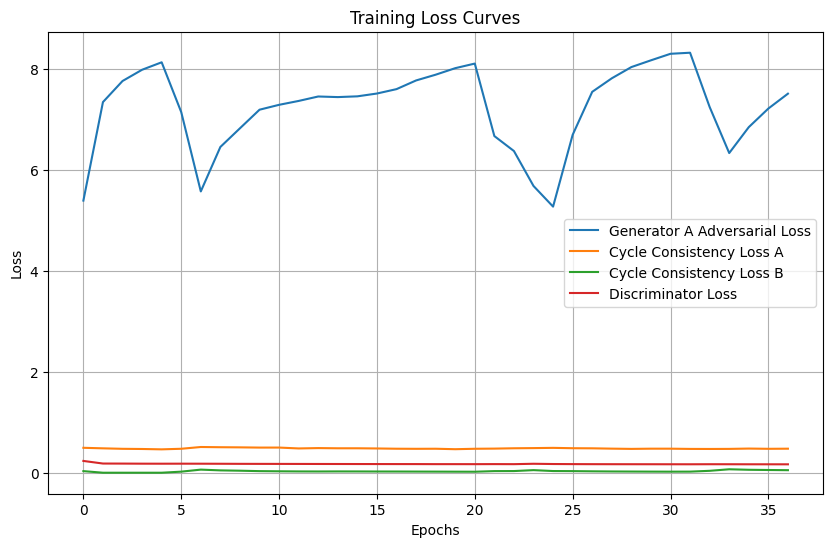

In [42]:
# plotting the loss curves
plt.figure(figsize=(10, 6))

plt.plot(losses["G_A"], label="Generator A Adversarial Loss")
plt.plot(losses["Cycle_A"], label="Cycle Consistency Loss A")
plt.plot(losses["Cycle_B"], label="Cycle Consistency Loss B")
plt.plot(losses["D"], label="Discriminator Loss")

plt.title("Training Loss Curves")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

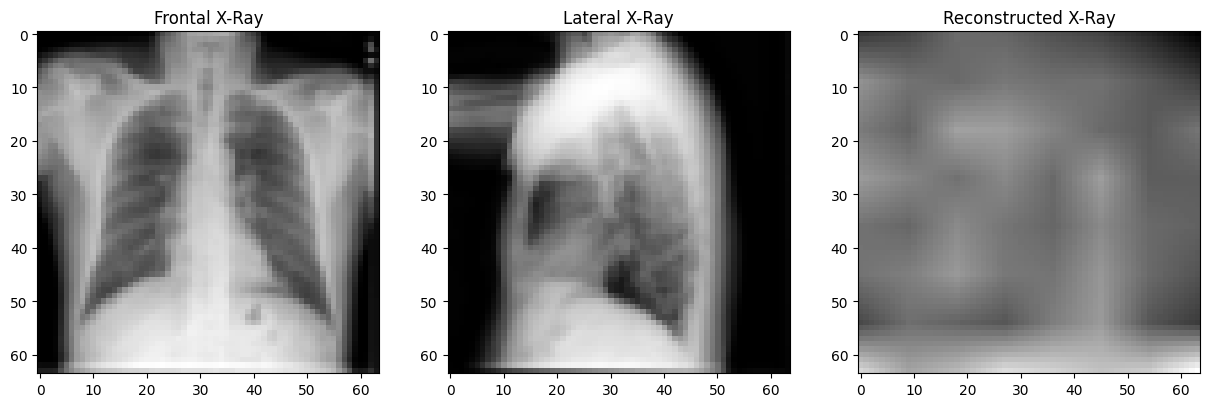

In [43]:
def visualize_results(generator_2d_to_3d, generator_3d_to_2d, frontal, lateral, device):
    generator_2d_to_3d.eval()
    generator_3d_to_2d.eval()

    # Prepare input
    frontal = frontal.unsqueeze(0).to(device)  # Add batch dimension
    lateral = lateral.unsqueeze(0).to(device)  # Add batch dimension
    input_xrays = torch.cat((frontal, lateral), dim=1)

    with torch.no_grad():
        fake_3d = generator_2d_to_3d(input_xrays)
        reconstructed_xrays = generator_3d_to_2d(fake_3d)

    # Select a single channel or average across channels
    reconstructed_image = reconstructed_xrays[0].mean(dim=0).cpu().numpy()  # Average channels
    frontal_image = frontal[0][0].cpu().numpy()  # First channel of frontal view
    lateral_image = lateral[0][0].cpu().numpy()  # First channel of lateral view

    # Plot images
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(frontal_image, cmap='gray')
    axes[0].set_title("Frontal X-Ray")
    axes[1].imshow(lateral_image, cmap='gray')
    axes[1].set_title("Lateral X-Ray")
    axes[2].imshow(reconstructed_image, cmap='gray')
    axes[2].set_title("Reconstructed X-Ray")
    plt.show()

# Get a sample from the dataset
sample = next(iter(test_loader))
frontal_sample, lateral_sample = sample['frontal'][0], sample['lateral'][0]

# Visualize the results
visualize_results(generator_2d_to_3d, generator_3d_to_2d, frontal_sample, lateral_sample, device)


In [46]:
fake_3d.shape

torch.Size([16, 1, 64, 64, 64])

## CYCLEGAN - BIPLANAR IMAGES - LAMBDA 10

In [23]:
# TRAINING LOOP

# initializing lists to track losses for plotting
losses = {
    "G_A": [],           # Generator A adversarial loss
    "Cycle_A": [],       # cycle consistency loss A (2D->3D->2D)
    "Cycle_B": [],       # cycle consistency loss B (3D->2D->3D)
    "D": []              # discriminator loss
}

num_epochs = 50
lambda_cycle = 10
adversarial_loss = nn.BCEWithLogitsLoss()
cycle_consistency_loss = nn.L1Loss()
label_smoothing = 0.1

for epoch in range(num_epochs):
    generator_2d_to_3d.train()
    generator_3d_to_2d.train()
    discriminator_3d.train()

    epoch_loss_G_A = 0.0
    epoch_loss_Cycle_A = 0.0
    epoch_loss_Cycle_B = 0.0
    epoch_loss_D = 0.0

    for i, batch in enumerate(tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]")):
        frontal, lateral = batch['frontal'].to(device), batch['lateral'].to(device)
        input_xrays = torch.cat((frontal, lateral), dim=1)

        # -------------------
        # Train Generator A (2D to 3D)
        # -------------------
        optimizer_G_A.zero_grad()
        fake_3d = generator_2d_to_3d(input_xrays)
        real_labels = (1.0 - label_smoothing) * torch.ones_like(discriminator_3d(fake_3d)).to(device)
        loss_G_A_adv = adversarial_loss(discriminator_3d(fake_3d), real_labels)

        # Train Generator B (3D to 2D)
        optimizer_G_B.zero_grad()
        reconstructed_xrays = generator_3d_to_2d(fake_3d)
        loss_cycle_A = cycle_consistency_loss(reconstructed_xrays, input_xrays)

        reconstructed_volumes = generator_2d_to_3d(reconstructed_xrays)
        loss_cycle_B = cycle_consistency_loss(reconstructed_volumes, fake_3d)

        loss_G = loss_G_A_adv + lambda_cycle * (loss_cycle_A + loss_cycle_B)
        loss_G.backward()

        # gradient clipping for the generators
        torch.nn.utils.clip_grad_norm_(generator_2d_to_3d.parameters(), max_norm=1.0)
        torch.nn.utils.clip_grad_norm_(generator_3d_to_2d.parameters(), max_norm=1.0)

        optimizer_G_A.step()
        optimizer_G_B.step()

        # -------------------
        # Train Discriminator (3D)
        # -------------------
        if i % 2 == 0:  # balancing training steps
            optimizer_D.zero_grad()
            real_3d = torch.randn_like(fake_3d).to(device)
            real_scores = discriminator_3d(real_3d)
            real_labels = (1.0 - label_smoothing) * torch.ones_like(real_scores).to(device)
            loss_real = adversarial_loss(real_scores, real_labels)

            fake_scores = discriminator_3d(fake_3d.detach())
            fake_labels = label_smoothing * torch.zeros_like(fake_scores).to(device)
            loss_fake = adversarial_loss(fake_scores, fake_labels)

            loss_D = (loss_real + loss_fake) / 2
            loss_D.backward()

            # gradient clipping for the discriminator
            torch.nn.utils.clip_grad_norm_(discriminator_3d.parameters(), max_norm=1.0)

            optimizer_D.step()

        # accumulating losses
        epoch_loss_G_A += loss_G_A_adv.item()
        epoch_loss_Cycle_A += loss_cycle_A.item()
        epoch_loss_Cycle_B += loss_cycle_B.item()
        epoch_loss_D += loss_D.item() if i % 2 == 0 else 0.0

    # calculating average losses
    avg_loss_G_A = epoch_loss_G_A / len(train_loader)
    avg_loss_Cycle_A = epoch_loss_Cycle_A / len(train_loader)
    avg_loss_Cycle_B = epoch_loss_Cycle_B / len(train_loader)
    avg_loss_D = epoch_loss_D / (len(train_loader) / 2)

    # appending epoch losses to the dictionary
    losses["G_A"].append(avg_loss_G_A)
    losses["Cycle_A"].append(avg_loss_Cycle_A)
    losses["Cycle_B"].append(avg_loss_Cycle_B)
    losses["D"].append(avg_loss_D)

    print(
        f"Epoch [{epoch+1}/{num_epochs}] Training: "
        f"Loss_G_A: {avg_loss_G_A:.4f} | "
        f"Loss_Cycle_A: {avg_loss_Cycle_A:.4f} | "
        f"Loss_Cycle_B: {avg_loss_Cycle_B:.4f} | "
        f"Loss_D: {avg_loss_D:.4f}"
    )

    # saving checkpoints every 25 epochs
    if (epoch + 1) % 25 == 0:
        torch.save(generator_2d_to_3d.state_dict(), f"generator_2d_to_3d_epoch_{epoch+1}.pth")
        torch.save(generator_3d_to_2d.state_dict(), f"generator_3d_to_2d_epoch_{epoch+1}.pth")
        torch.save(discriminator_3d.state_dict(), f"discriminator_epoch_{epoch+1}.pth")


Epoch [1/50]: 100%|██████████| 180/180 [11:16<00:00,  3.76s/it]


Epoch [1/50] Training: Loss_G_A: 2.5218 | Loss_Cycle_A: 0.5309 | Loss_Cycle_B: 0.1854 | Loss_D: 0.3633


Epoch [2/50]: 100%|██████████| 180/180 [11:13<00:00,  3.74s/it]


Epoch [2/50] Training: Loss_G_A: 5.4164 | Loss_Cycle_A: 0.5365 | Loss_Cycle_B: 0.1267 | Loss_D: 0.1858


Epoch [3/50]: 100%|██████████| 180/180 [11:13<00:00,  3.74s/it]


Epoch [3/50] Training: Loss_G_A: 6.3756 | Loss_Cycle_A: 0.5477 | Loss_Cycle_B: 0.0964 | Loss_D: 0.1837


Epoch [4/50]: 100%|██████████| 180/180 [11:13<00:00,  3.74s/it]


Epoch [4/50] Training: Loss_G_A: 6.4540 | Loss_Cycle_A: 0.5413 | Loss_Cycle_B: 0.0824 | Loss_D: 0.1822


Epoch [5/50]: 100%|██████████| 180/180 [11:12<00:00,  3.74s/it]


Epoch [5/50] Training: Loss_G_A: 6.8115 | Loss_Cycle_A: 0.5312 | Loss_Cycle_B: 0.0699 | Loss_D: 0.1812


Epoch [6/50]: 100%|██████████| 180/180 [11:13<00:00,  3.74s/it]


Epoch [6/50] Training: Loss_G_A: 7.1423 | Loss_Cycle_A: 0.5369 | Loss_Cycle_B: 0.0556 | Loss_D: 0.1797


Epoch [7/50]: 100%|██████████| 180/180 [11:13<00:00,  3.74s/it]


Epoch [7/50] Training: Loss_G_A: 7.1961 | Loss_Cycle_A: 0.5502 | Loss_Cycle_B: 0.0493 | Loss_D: 0.1790


Epoch [8/50]: 100%|██████████| 180/180 [11:13<00:00,  3.74s/it]


Epoch [8/50] Training: Loss_G_A: 6.3763 | Loss_Cycle_A: 0.5384 | Loss_Cycle_B: 0.0700 | Loss_D: 0.1795


Epoch [9/50]: 100%|██████████| 180/180 [11:13<00:00,  3.74s/it]


Epoch [9/50] Training: Loss_G_A: 5.9693 | Loss_Cycle_A: 0.5412 | Loss_Cycle_B: 0.0794 | Loss_D: 0.1781


Epoch [10/50]: 100%|██████████| 180/180 [11:13<00:00,  3.74s/it]


Epoch [10/50] Training: Loss_G_A: 5.4707 | Loss_Cycle_A: 0.5336 | Loss_Cycle_B: 0.1002 | Loss_D: 0.1833


Epoch [11/50]: 100%|██████████| 180/180 [11:13<00:00,  3.74s/it]


Epoch [11/50] Training: Loss_G_A: 4.6900 | Loss_Cycle_A: 0.5478 | Loss_Cycle_B: 0.1265 | Loss_D: 0.1835


Epoch [12/50]: 100%|██████████| 180/180 [11:13<00:00,  3.74s/it]


Epoch [12/50] Training: Loss_G_A: 4.0300 | Loss_Cycle_A: 0.5430 | Loss_Cycle_B: 0.2126 | Loss_D: 0.2027


Epoch [13/50]: 100%|██████████| 180/180 [11:13<00:00,  3.74s/it]


Epoch [13/50] Training: Loss_G_A: 4.0410 | Loss_Cycle_A: 0.5601 | Loss_Cycle_B: 0.2800 | Loss_D: 0.2230


Epoch [14/50]: 100%|██████████| 180/180 [11:14<00:00,  3.75s/it]


Epoch [14/50] Training: Loss_G_A: 3.4138 | Loss_Cycle_A: 0.5358 | Loss_Cycle_B: 0.3104 | Loss_D: 0.2306


Epoch [15/50]: 100%|██████████| 180/180 [11:13<00:00,  3.74s/it]


Epoch [15/50] Training: Loss_G_A: 3.6634 | Loss_Cycle_A: 0.5468 | Loss_Cycle_B: 0.3934 | Loss_D: 0.2061


Epoch [16/50]: 100%|██████████| 180/180 [11:13<00:00,  3.74s/it]


Epoch [16/50] Training: Loss_G_A: 3.9077 | Loss_Cycle_A: 0.5541 | Loss_Cycle_B: 0.4292 | Loss_D: 0.1988


Epoch [17/50]: 100%|██████████| 180/180 [11:13<00:00,  3.74s/it]


Epoch [17/50] Training: Loss_G_A: 4.4473 | Loss_Cycle_A: 0.5388 | Loss_Cycle_B: 0.3799 | Loss_D: 0.1887


Epoch [18/50]: 100%|██████████| 180/180 [11:13<00:00,  3.74s/it]


Epoch [18/50] Training: Loss_G_A: 4.7815 | Loss_Cycle_A: 0.5482 | Loss_Cycle_B: 0.3521 | Loss_D: 0.1868


Epoch [19/50]: 100%|██████████| 180/180 [11:13<00:00,  3.74s/it]


Epoch [19/50] Training: Loss_G_A: 5.1133 | Loss_Cycle_A: 0.5478 | Loss_Cycle_B: 0.3160 | Loss_D: 0.1838


Epoch [20/50]: 100%|██████████| 180/180 [11:13<00:00,  3.74s/it]


Epoch [20/50] Training: Loss_G_A: 5.0763 | Loss_Cycle_A: 0.5108 | Loss_Cycle_B: 0.2522 | Loss_D: 0.1834


Epoch [21/50]: 100%|██████████| 180/180 [11:11<00:00,  3.73s/it]


Epoch [21/50] Training: Loss_G_A: 4.7983 | Loss_Cycle_A: 0.5312 | Loss_Cycle_B: 0.2383 | Loss_D: 0.1836


Epoch [22/50]: 100%|██████████| 180/180 [11:09<00:00,  3.72s/it]


Epoch [22/50] Training: Loss_G_A: 5.4478 | Loss_Cycle_A: 0.5554 | Loss_Cycle_B: 0.1842 | Loss_D: 0.1842


Epoch [23/50]: 100%|██████████| 180/180 [11:09<00:00,  3.72s/it]


Epoch [23/50] Training: Loss_G_A: 4.8490 | Loss_Cycle_A: 0.5448 | Loss_Cycle_B: 0.1983 | Loss_D: 0.1901


Epoch [24/50]: 100%|██████████| 180/180 [11:09<00:00,  3.72s/it]


Epoch [24/50] Training: Loss_G_A: 5.3604 | Loss_Cycle_A: 0.5447 | Loss_Cycle_B: 0.1770 | Loss_D: 0.1814


Epoch [25/50]: 100%|██████████| 180/180 [11:08<00:00,  3.72s/it]


Epoch [25/50] Training: Loss_G_A: 5.8725 | Loss_Cycle_A: 0.5417 | Loss_Cycle_B: 0.1374 | Loss_D: 0.1792


Epoch [26/50]: 100%|██████████| 180/180 [11:08<00:00,  3.72s/it]


Epoch [26/50] Training: Loss_G_A: 5.2015 | Loss_Cycle_A: 0.5350 | Loss_Cycle_B: 0.1851 | Loss_D: 0.1793


Epoch [27/50]: 100%|██████████| 180/180 [11:09<00:00,  3.72s/it]


Epoch [27/50] Training: Loss_G_A: 5.3720 | Loss_Cycle_A: 0.5365 | Loss_Cycle_B: 0.1436 | Loss_D: 0.1781


Epoch [28/50]: 100%|██████████| 180/180 [11:10<00:00,  3.72s/it]


Epoch [28/50] Training: Loss_G_A: 5.1776 | Loss_Cycle_A: 0.5404 | Loss_Cycle_B: 0.1696 | Loss_D: 0.1780


Epoch [29/50]: 100%|██████████| 180/180 [11:09<00:00,  3.72s/it]


Epoch [29/50] Training: Loss_G_A: 5.5530 | Loss_Cycle_A: 0.5312 | Loss_Cycle_B: 0.1454 | Loss_D: 0.1765


Epoch [30/50]: 100%|██████████| 180/180 [11:10<00:00,  3.72s/it]


Epoch [30/50] Training: Loss_G_A: 5.4935 | Loss_Cycle_A: 0.5304 | Loss_Cycle_B: 0.1718 | Loss_D: 0.1760


Epoch [31/50]: 100%|██████████| 180/180 [11:09<00:00,  3.72s/it]


Epoch [31/50] Training: Loss_G_A: 5.4499 | Loss_Cycle_A: 0.5389 | Loss_Cycle_B: 0.1738 | Loss_D: 0.1759


Epoch [32/50]: 100%|██████████| 180/180 [11:09<00:00,  3.72s/it]


Epoch [32/50] Training: Loss_G_A: 5.6242 | Loss_Cycle_A: 0.5337 | Loss_Cycle_B: 0.1731 | Loss_D: 0.1750


Epoch [33/50]: 100%|██████████| 180/180 [11:08<00:00,  3.71s/it]


Epoch [33/50] Training: Loss_G_A: 5.8877 | Loss_Cycle_A: 0.5200 | Loss_Cycle_B: 0.1263 | Loss_D: 0.1746


Epoch [34/50]: 100%|██████████| 180/180 [11:09<00:00,  3.72s/it]


Epoch [34/50] Training: Loss_G_A: 5.8383 | Loss_Cycle_A: 0.5438 | Loss_Cycle_B: 0.1351 | Loss_D: 0.1736


Epoch [35/50]: 100%|██████████| 180/180 [11:09<00:00,  3.72s/it]


Epoch [35/50] Training: Loss_G_A: 5.5845 | Loss_Cycle_A: 0.5422 | Loss_Cycle_B: 0.1429 | Loss_D: 0.1738


Epoch [36/50]: 100%|██████████| 180/180 [11:09<00:00,  3.72s/it]


Epoch [36/50] Training: Loss_G_A: 5.8718 | Loss_Cycle_A: 0.5269 | Loss_Cycle_B: 0.1395 | Loss_D: 0.1727


Epoch [37/50]: 100%|██████████| 180/180 [11:08<00:00,  3.72s/it]


Epoch [37/50] Training: Loss_G_A: 6.0909 | Loss_Cycle_A: 0.5273 | Loss_Cycle_B: 0.1273 | Loss_D: 0.1722


Epoch [38/50]: 100%|██████████| 180/180 [11:08<00:00,  3.71s/it]


Epoch [38/50] Training: Loss_G_A: 6.0209 | Loss_Cycle_A: 0.5260 | Loss_Cycle_B: 0.1235 | Loss_D: 0.1718


Epoch [39/50]: 100%|██████████| 180/180 [11:08<00:00,  3.72s/it]


Epoch [39/50] Training: Loss_G_A: 6.2424 | Loss_Cycle_A: 0.5359 | Loss_Cycle_B: 0.1228 | Loss_D: 0.1712


Epoch [40/50]: 100%|██████████| 180/180 [11:09<00:00,  3.72s/it]


Epoch [40/50] Training: Loss_G_A: 6.0950 | Loss_Cycle_A: 0.5155 | Loss_Cycle_B: 0.1280 | Loss_D: 0.1709


Epoch [41/50]: 100%|██████████| 180/180 [11:09<00:00,  3.72s/it]


Epoch [41/50] Training: Loss_G_A: 6.3664 | Loss_Cycle_A: 0.5496 | Loss_Cycle_B: 0.1278 | Loss_D: 0.1705


Epoch [42/50]: 100%|██████████| 180/180 [11:10<00:00,  3.72s/it]


Epoch [42/50] Training: Loss_G_A: 6.4850 | Loss_Cycle_A: 0.5390 | Loss_Cycle_B: 0.1257 | Loss_D: 0.1697


Epoch [43/50]: 100%|██████████| 180/180 [11:10<00:00,  3.73s/it]


Epoch [43/50] Training: Loss_G_A: 6.3004 | Loss_Cycle_A: 0.5447 | Loss_Cycle_B: 0.1421 | Loss_D: 0.1699


Epoch [44/50]: 100%|██████████| 180/180 [11:10<00:00,  3.73s/it]


Epoch [44/50] Training: Loss_G_A: 6.1533 | Loss_Cycle_A: 0.5271 | Loss_Cycle_B: 0.1512 | Loss_D: 0.1696


Epoch [45/50]: 100%|██████████| 180/180 [11:10<00:00,  3.72s/it]


Epoch [45/50] Training: Loss_G_A: 6.2304 | Loss_Cycle_A: 0.5476 | Loss_Cycle_B: 0.1363 | Loss_D: 0.1693


Epoch [46/50]: 100%|██████████| 180/180 [11:09<00:00,  3.72s/it]


Epoch [46/50] Training: Loss_G_A: 6.0992 | Loss_Cycle_A: 0.5230 | Loss_Cycle_B: 0.1238 | Loss_D: 0.1692


Epoch [47/50]: 100%|██████████| 180/180 [11:09<00:00,  3.72s/it]


Epoch [47/50] Training: Loss_G_A: 6.2382 | Loss_Cycle_A: 0.5469 | Loss_Cycle_B: 0.1240 | Loss_D: 0.1689


Epoch [48/50]: 100%|██████████| 180/180 [11:10<00:00,  3.72s/it]


Epoch [48/50] Training: Loss_G_A: 6.4947 | Loss_Cycle_A: 0.5520 | Loss_Cycle_B: 0.1289 | Loss_D: 0.1685


Epoch [49/50]: 100%|██████████| 180/180 [11:10<00:00,  3.73s/it]


Epoch [49/50] Training: Loss_G_A: 6.5065 | Loss_Cycle_A: 0.5187 | Loss_Cycle_B: 0.1438 | Loss_D: 0.1684


Epoch [50/50]:  58%|█████▊    | 105/180 [06:34<04:41,  3.76s/it]


KeyboardInterrupt: 

In [24]:
losses

{'G_A': [2.521820890241199,
  5.41640596124861,
  6.375580045912001,
  6.453997373580933,
  6.811502570576138,
  7.142253647910224,
  7.1960572878519695,
  6.376273164484236,
  5.969266049067179,
  5.470694179005093,
  4.689964452054766,
  4.0300338685512545,
  4.040971877177556,
  3.4137643012735577,
  3.6634193738301595,
  3.907739754517873,
  4.447302571932474,
  4.781530349784427,
  5.113264001740349,
  5.0763090584013195,
  4.7982816841867235,
  5.4477630509270565,
  4.848991903993818,
  5.360432558589512,
  5.872475955221388,
  5.201461746957567,
  5.37203967306349,
  5.177563563982646,
  5.55299404197269,
  5.493503798378838,
  5.449861017862956,
  5.624173890219795,
  5.887730815675524,
  5.838267392582363,
  5.584542184405857,
  5.871788718965319,
  6.090884274906582,
  6.020860550138686,
  6.242417534192403,
  6.0949655453364056,
  6.36635791460673,
  6.485045756234063,
  6.300355916553073,
  6.153327473004659,
  6.230414160092672,
  6.099163730939229,
  6.238162753317091,
  

## CYCLEGAN - FRONTAL ONLY

In [15]:
# 3D residual block
class ResidualBlock3D(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock3D, self).__init__()
        self.block = nn.Sequential(
            nn.Conv3d(channels, channels, kernel_size=3, stride=1, padding=1),
            nn.InstanceNorm3d(channels),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.3),
            nn.Conv3d(channels, channels, kernel_size=3, stride=1, padding=1),
            nn.InstanceNorm3d(channels)
        )

    def forward(self, x):
        return x + self.block(x)


class CycleGANGenerator3D(nn.Module):
    def __init__(self, input_channels=1, output_channels=1, num_residual_blocks=6, target_depth=64):
        super(CycleGANGenerator3D, self).__init__()
        self.target_depth = target_depth

        # initial convolution clock
        self.initial = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=7, stride=1, padding=3),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.3)
        )

        # downsampling layers
        self.downsampling = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # (64, 64) -> (32, 32)
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),  # 32, 32) -> (16, 16)
            nn.InstanceNorm2d(256),
            nn.ReLU(inplace=True)
        )

        # reshaping to 3D
        self.reshape_to_3d = nn.Conv3d(256, 256, kernel_size=(1, 1, 1))

        # residual blocks
        self.residual_blocks = nn.Sequential(
            *[ResidualBlock3D(256) for _ in range(num_residual_blocks)]
        )

        # upsampling layers
        self.upsampling = nn.Sequential(
            nn.ConvTranspose3d(256, 128, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1), output_padding=(0, 0, 0)),  # (16, 16, 16) -> (32, 32, 32)
            nn.InstanceNorm3d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.3),
            nn.ConvTranspose3d(128, 64, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1), output_padding=(0, 0, 0)),  # (32, 32, 32) -> (64, 64, 64)
            nn.InstanceNorm3d(64),
            nn.ReLU(inplace=True)
        )

        # output layer
        self.output_layer = nn.Sequential(
            nn.Conv3d(64, output_channels, kernel_size=7, stride=1, padding=3),
            nn.Tanh()
        )

    def forward(self, x):
        # processing 2D input
        x = self.initial(x)

        x = self.downsampling(x)

        # reshape to add a depth dimension
        x = x.unsqueeze(2)  

        x = self.reshape_to_3d(x)

        x = self.residual_blocks(x)

        x = self.upsampling(x)

        # resizing to final 3D volume
        x = nn.functional.interpolate(x, size=(self.target_depth, 64, 64), mode='trilinear', align_corners=True)

        return self.output_layer(x)

# instantiating the generator for 64x64 inputs and 64x64x64 outputs
generator_3d = CycleGANGenerator3D(input_channels=1, output_channels=1, target_depth=64)

# TESTING THE GENERATOR with a dummy input of size 64x64
dummy_input_2d = torch.randn(1, 1, 64, 64)  
output_3d = generator_3d(dummy_input_2d)
print(f"Input shape: {dummy_input_2d.shape}")
print(f"Output shape: {output_3d.shape}")


Input shape: torch.Size([1, 1, 64, 64])
Output shape: torch.Size([1, 1, 64, 64, 64])


In [16]:
class Generator3DTo2D(nn.Module):
    def __init__(self, input_channels=1, output_channels=1):
        super(Generator3DTo2D, self).__init__()

        # 3D feature extraction layers
        self.feature_extraction = nn.Sequential(
            nn.Conv3d(input_channels, 64, kernel_size=4, stride=2, padding=1),  # (64, 64, 64) -> (32, 32, 32)
            nn.InstanceNorm3d(64),
            nn.ReLU(inplace=True),

            nn.Conv3d(64, 128, kernel_size=4, stride=2, padding=1),  # (32, 32, 32) -> (16, 16, 16)
            nn.InstanceNorm3d(128),
            nn.ReLU(inplace=True),

            nn.Conv3d(128, 256, kernel_size=4, stride=2, padding=1),  # (16, 16, 16) -> (8, 8, 8)
            nn.InstanceNorm3d(256),
            nn.ReLU(inplace=True),
        )

        self.output_channels = output_channels

        # 2D upsampling layer
        self.upsample = nn.Upsample(scale_factor=8, mode="bilinear", align_corners=True)

    def forward(self, x):
        # feature extraction from 3D
        x = self.feature_extraction(x)

        # flattenning the 3D volume into 2D
        batch_size, channels, depth, height, width = x.shape
        x = x.view(batch_size, channels * depth, height, width)  # Merge depth dimension into channels

        # reducing the output channels
        final_conv = nn.Conv2d(
            in_channels=channels * depth, out_channels=self.output_channels,
            kernel_size=1, stride=1, padding=0
        ).to(x.device)  

        x = final_conv(x)  

        # upsampling to restore original 2D dimensions
        x = self.upsample(x)  
        return x

# TESTING THE GENERATOR with dummy input
dummy_input_3d = torch.randn(1, 1, 64, 64, 64).to(device)  
generator_3d_to_2d = Generator3DTo2D(input_channels=1, output_channels=1).to(device)  
output_2d = generator_3d_to_2d(dummy_input_3d)

print(f"Input shape (3D): {dummy_input_3d.shape}")
print(f"Output shape (2D): {output_2d.shape}")


Input shape (3D): torch.Size([1, 1, 64, 64, 64])
Output shape (2D): torch.Size([1, 1, 64, 64])


In [17]:
class PatchGANDiscriminator3D(nn.Module):
    def __init__(self, input_channels=1):
        super(PatchGANDiscriminator3D, self).__init__()
        
        # convolutional layers
        self.model = nn.Sequential(
            nn.Conv3d(input_channels, 64, kernel_size=4, stride=2, padding=1),  # (64 -> 32)
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv3d(64, 128, kernel_size=4, stride=2, padding=1),  # (32 -> 16)
            nn.InstanceNorm3d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(p=0.3),
            
            nn.Conv3d(128, 256, kernel_size=4, stride=2, padding=1),  # (16 -> 8)
            nn.InstanceNorm3d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(p=0.3),
            
            nn.Conv3d(256, 512, kernel_size=4, stride=2, padding=1),  # (8 -> 4)
            nn.InstanceNorm3d(512),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv3d(512, 1, kernel_size=3, stride=1, padding=0)  # (4 -> 2)
        )

    def forward(self, x):
        return self.model(x)

# instantiating the discriminator
discriminator_3d = PatchGANDiscriminator3D(input_channels=1)

# TESTING THE DISCRIMINATOR with a dummy input of size 64x64x64
dummy_input_3d = torch.randn(1, 1, 64, 64, 64)  # Batch size of 1
output = discriminator_3d(dummy_input_3d)
print(f"Input shape: {dummy_input_3d.shape}")
print(f"Output shape: {output.shape}")


Input shape: torch.Size([1, 1, 64, 64, 64])
Output shape: torch.Size([1, 1, 2, 2, 2])


In [18]:
# loss functions
adversarial_loss = nn.BCEWithLogitsLoss()  
cycle_consistency_loss = nn.L1Loss()  # reconstruction consistency

# optimizers
lr = 1e-5
beta1, beta2 = 0.5, 0.999

optimizer_G = Adam(generator_3d.parameters(), lr=lr, betas=(beta1, beta2))
optimizer_D = Adam(discriminator_3d.parameters(), lr=lr, betas=(beta1, beta2))

# device
generator_3d.to(device)
discriminator_3d.to(device)

PatchGANDiscriminator3D(
  (model): Sequential(
    (0): Conv3d(1, 64, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv3d(64, 128, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
    (3): InstanceNorm3d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Dropout(p=0.3, inplace=False)
    (6): Conv3d(128, 256, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
    (7): InstanceNorm3d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Dropout(p=0.3, inplace=False)
    (10): Conv3d(256, 512, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
    (11): InstanceNorm3d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (12): LeakyReLU(negative_slope=0.2, inplace=True)
    (13): Conv3d(512, 1, kernel_si

In [20]:
# instantiating generators for frontal input
input_channels_2d = 1  # 1 for frontal
input_channels_3d = 1  
output_channels_2d = 1  # 1 channel for frontal
output_channels_3d = 1  

# generators
generator_2d_to_3d = CycleGANGenerator3D(input_channels=input_channels_2d, output_channels=output_channels_3d).to(device)
generator_3d_to_2d = Generator3DTo2D(input_channels=input_channels_3d, output_channels=output_channels_2d).to(device)

# optimizers
optimizer_G_A = Adam(generator_2d_to_3d.parameters(), lr=1e-5, betas=(0.5, 0.999))
optimizer_G_B = Adam(generator_3d_to_2d.parameters(), lr=1e-5, betas=(0.5, 0.999))

# discriminator
discriminator_3d = PatchGANDiscriminator3D(input_channels=1).to(device)
optimizer_D = Adam(discriminator_3d.parameters(), lr=1e-5, betas=(0.5, 0.999))


In [21]:
# weight initialization
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.Conv3d, nn.ConvTranspose3d)):
            init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='leaky_relu')
        elif isinstance(m, (nn.InstanceNorm2d, nn.InstanceNorm3d)) and m.weight is not None:
            init.constant_(m.weight, 1)
            init.constant_(m.bias, 0)

# initializing weights
initialize_weights(generator_2d_to_3d)
initialize_weights(generator_3d_to_2d)
initialize_weights(discriminator_3d)

In [24]:
# TRAINING LOOP

# initializing lists to track losses for plotting
losses = {
    "G_A": [],           # generator A adversarial loss
    "Cycle_A": [],       # cycle consistency loss A (2D->3D->2D)
    "Cycle_B": [],       # cycle consistency loss B (3D->2D->3D)
    "D": []              # discriminator loss
}

num_epochs = 50
lambda_cycle = 15
adversarial_loss = nn.BCEWithLogitsLoss()
cycle_consistency_loss = nn.L1Loss()
label_smoothing = 0.1

for epoch in range(num_epochs):
    generator_2d_to_3d.train()
    generator_3d_to_2d.train()
    discriminator_3d.train()

    epoch_loss_G_A = 0.0
    epoch_loss_Cycle_A = 0.0
    epoch_loss_Cycle_B = 0.0
    epoch_loss_D = 0.0

    for i, batch in enumerate(tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]")):
        frontal = batch['frontal'].to(device)

        # -------------------
        # Train Generator A (2D to 3D)
        # -------------------
        optimizer_G_A.zero_grad()
        fake_3d = generator_2d_to_3d(frontal)
        real_labels = (1.0 - label_smoothing) * torch.ones_like(discriminator_3d(fake_3d)).to(device)
        loss_G_A_adv = adversarial_loss(discriminator_3d(fake_3d), real_labels)

        # Train Generator B (3D to 2D)
        optimizer_G_B.zero_grad()
        reconstructed_xrays = generator_3d_to_2d(fake_3d)
        loss_cycle_A = cycle_consistency_loss(reconstructed_xrays, frontal)

        reconstructed_volumes = generator_2d_to_3d(reconstructed_xrays)
        loss_cycle_B = cycle_consistency_loss(reconstructed_volumes, fake_3d)

        loss_G = loss_G_A_adv + lambda_cycle * (loss_cycle_A + loss_cycle_B)
        loss_G.backward()

        # gradient clipping for the generators
        torch.nn.utils.clip_grad_norm_(generator_2d_to_3d.parameters(), max_norm=1.0)
        torch.nn.utils.clip_grad_norm_(generator_3d_to_2d.parameters(), max_norm=1.0)

        optimizer_G_A.step()
        optimizer_G_B.step()

        # -------------------
        # Train Discriminator (3D)
        # -------------------
        if i % 2 == 0:  # balancing training steps
            optimizer_D.zero_grad()
            real_3d = torch.randn_like(fake_3d).to(device)  # random 3D volume
            real_scores = discriminator_3d(real_3d)
            real_labels = (1.0 - label_smoothing) * torch.ones_like(real_scores).to(device)
            loss_real = adversarial_loss(real_scores, real_labels)

            fake_scores = discriminator_3d(fake_3d.detach())
            fake_labels = label_smoothing * torch.zeros_like(fake_scores).to(device)
            loss_fake = adversarial_loss(fake_scores, fake_labels)

            loss_D = (loss_real + loss_fake) / 2
            loss_D.backward()

            # gradient clipping for the discriminator
            torch.nn.utils.clip_grad_norm_(discriminator_3d.parameters(), max_norm=1.0)

            optimizer_D.step()

        # accumulating losses
        epoch_loss_G_A += loss_G_A_adv.item()
        epoch_loss_Cycle_A += loss_cycle_A.item()
        epoch_loss_Cycle_B += loss_cycle_B.item()
        epoch_loss_D += loss_D.item() if i % 2 == 0 else 0.0

    # calculating average losses
    avg_loss_G_A = epoch_loss_G_A / len(train_loader)
    avg_loss_Cycle_A = epoch_loss_Cycle_A / len(train_loader)
    avg_loss_Cycle_B = epoch_loss_Cycle_B / len(train_loader)
    avg_loss_D = epoch_loss_D / (len(train_loader) / 2)

    # appending epoch losses to the dictionary
    losses["G_A"].append(avg_loss_G_A)
    losses["Cycle_A"].append(avg_loss_Cycle_A)
    losses["Cycle_B"].append(avg_loss_Cycle_B)
    losses["D"].append(avg_loss_D)

    print(
        f"Epoch [{epoch+1}/{num_epochs}] Training: "
        f"Loss_G_A: {avg_loss_G_A:.4f} | "
        f"Loss_Cycle_A: {avg_loss_Cycle_A:.4f} | "
        f"Loss_Cycle_B: {avg_loss_Cycle_B:.4f} | "
        f"Loss_D: {avg_loss_D:.4f}"
    )

    # saving checkpoints every 10 epochs
    if (epoch + 1) % 25 == 0:
        torch.save(generator_2d_to_3d.state_dict(), f"generatorfrontal_2d_to_3d_epoch_{epoch+1}.pth")
        torch.save(generator_3d_to_2d.state_dict(), f"generatorfrontal_3d_to_2d_epoch_{epoch+1}.pth")
        torch.save(discriminator_3d.state_dict(), f"discriminatorfrontal_epoch_{epoch+1}.pth")



Epoch [1/50]: 100%|██████████| 180/180 [11:13<00:00,  3.74s/it]


Epoch [1/50] Training: Loss_G_A: 5.2726 | Loss_Cycle_A: 0.5480 | Loss_Cycle_B: 0.1515 | Loss_D: 0.1865


Epoch [2/50]: 100%|██████████| 180/180 [11:14<00:00,  3.75s/it]


Epoch [2/50] Training: Loss_G_A: 6.2372 | Loss_Cycle_A: 0.5525 | Loss_Cycle_B: 0.1095 | Loss_D: 0.1833


Epoch [3/50]: 100%|██████████| 180/180 [11:14<00:00,  3.75s/it]


Epoch [3/50] Training: Loss_G_A: 6.3316 | Loss_Cycle_A: 0.5625 | Loss_Cycle_B: 0.1144 | Loss_D: 0.1826


Epoch [4/50]: 100%|██████████| 180/180 [11:14<00:00,  3.75s/it]


Epoch [4/50] Training: Loss_G_A: 6.6473 | Loss_Cycle_A: 0.5593 | Loss_Cycle_B: 0.1090 | Loss_D: 0.1813


Epoch [5/50]: 100%|██████████| 180/180 [11:14<00:00,  3.75s/it]


Epoch [5/50] Training: Loss_G_A: 6.5352 | Loss_Cycle_A: 0.5830 | Loss_Cycle_B: 0.0998 | Loss_D: 0.1800


Epoch [6/50]: 100%|██████████| 180/180 [11:14<00:00,  3.75s/it]


Epoch [6/50] Training: Loss_G_A: 6.4607 | Loss_Cycle_A: 0.5833 | Loss_Cycle_B: 0.1089 | Loss_D: 0.1793


Epoch [7/50]: 100%|██████████| 180/180 [11:14<00:00,  3.75s/it]


Epoch [7/50] Training: Loss_G_A: 6.8319 | Loss_Cycle_A: 0.5592 | Loss_Cycle_B: 0.0800 | Loss_D: 0.1786


Epoch [8/50]: 100%|██████████| 180/180 [11:14<00:00,  3.75s/it]


Epoch [8/50] Training: Loss_G_A: 6.9459 | Loss_Cycle_A: 0.5274 | Loss_Cycle_B: 0.0643 | Loss_D: 0.1775


Epoch [9/50]: 100%|██████████| 180/180 [11:14<00:00,  3.75s/it]


Epoch [9/50] Training: Loss_G_A: 7.1345 | Loss_Cycle_A: 0.5392 | Loss_Cycle_B: 0.0521 | Loss_D: 0.1768


Epoch [10/50]: 100%|██████████| 180/180 [11:14<00:00,  3.75s/it]


Epoch [10/50] Training: Loss_G_A: 7.2364 | Loss_Cycle_A: 0.5607 | Loss_Cycle_B: 0.0496 | Loss_D: 0.1761


Epoch [11/50]: 100%|██████████| 180/180 [11:14<00:00,  3.75s/it]


Epoch [11/50] Training: Loss_G_A: 6.8366 | Loss_Cycle_A: 0.5516 | Loss_Cycle_B: 0.0568 | Loss_D: 0.1754


Epoch [12/50]: 100%|██████████| 180/180 [11:14<00:00,  3.75s/it]


Epoch [12/50] Training: Loss_G_A: 6.8057 | Loss_Cycle_A: 0.5750 | Loss_Cycle_B: 0.0604 | Loss_D: 0.1747


Epoch [13/50]: 100%|██████████| 180/180 [11:14<00:00,  3.75s/it]


Epoch [13/50] Training: Loss_G_A: 7.3750 | Loss_Cycle_A: 0.5923 | Loss_Cycle_B: 0.0480 | Loss_D: 0.1741


Epoch [14/50]: 100%|██████████| 180/180 [11:14<00:00,  3.75s/it]


Epoch [14/50] Training: Loss_G_A: 5.2393 | Loss_Cycle_A: 0.5607 | Loss_Cycle_B: 0.0586 | Loss_D: 0.1776


Epoch [15/50]: 100%|██████████| 180/180 [11:14<00:00,  3.75s/it]


Epoch [15/50] Training: Loss_G_A: 5.2003 | Loss_Cycle_A: 0.5788 | Loss_Cycle_B: 0.0710 | Loss_D: 0.1773


Epoch [16/50]: 100%|██████████| 180/180 [11:14<00:00,  3.75s/it]


Epoch [16/50] Training: Loss_G_A: 4.9031 | Loss_Cycle_A: 0.5837 | Loss_Cycle_B: 0.1538 | Loss_D: 0.1812


Epoch [17/50]: 100%|██████████| 180/180 [11:14<00:00,  3.75s/it]


Epoch [17/50] Training: Loss_G_A: 5.1948 | Loss_Cycle_A: 0.5899 | Loss_Cycle_B: 0.1475 | Loss_D: 0.1790


Epoch [18/50]: 100%|██████████| 180/180 [11:14<00:00,  3.75s/it]


Epoch [18/50] Training: Loss_G_A: 4.6321 | Loss_Cycle_A: 0.5661 | Loss_Cycle_B: 0.2109 | Loss_D: 0.1859


Epoch [19/50]: 100%|██████████| 180/180 [11:14<00:00,  3.75s/it]


Epoch [19/50] Training: Loss_G_A: 4.5589 | Loss_Cycle_A: 0.5574 | Loss_Cycle_B: 0.2072 | Loss_D: 0.2077


Epoch [20/50]: 100%|██████████| 180/180 [11:14<00:00,  3.75s/it]


Epoch [20/50] Training: Loss_G_A: 5.0671 | Loss_Cycle_A: 0.5548 | Loss_Cycle_B: 0.2244 | Loss_D: 0.1798


Epoch [21/50]: 100%|██████████| 180/180 [11:14<00:00,  3.75s/it]


Epoch [21/50] Training: Loss_G_A: 4.8155 | Loss_Cycle_A: 0.5627 | Loss_Cycle_B: 0.2639 | Loss_D: 0.1811


Epoch [22/50]: 100%|██████████| 180/180 [11:14<00:00,  3.75s/it]


Epoch [22/50] Training: Loss_G_A: 5.2050 | Loss_Cycle_A: 0.5787 | Loss_Cycle_B: 0.2439 | Loss_D: 0.1785


Epoch [23/50]: 100%|██████████| 180/180 [11:14<00:00,  3.75s/it]


Epoch [23/50] Training: Loss_G_A: 4.9903 | Loss_Cycle_A: 0.5383 | Loss_Cycle_B: 0.2707 | Loss_D: 0.1787


Epoch [24/50]: 100%|██████████| 180/180 [11:13<00:00,  3.74s/it]


Epoch [24/50] Training: Loss_G_A: 5.2360 | Loss_Cycle_A: 0.5886 | Loss_Cycle_B: 0.2353 | Loss_D: 0.1774


Epoch [25/50]: 100%|██████████| 180/180 [11:14<00:00,  3.75s/it]


Epoch [25/50] Training: Loss_G_A: 5.2787 | Loss_Cycle_A: 0.5617 | Loss_Cycle_B: 0.2170 | Loss_D: 0.1766


Epoch [26/50]: 100%|██████████| 180/180 [11:14<00:00,  3.75s/it]


Epoch [26/50] Training: Loss_G_A: 4.9812 | Loss_Cycle_A: 0.5599 | Loss_Cycle_B: 0.2711 | Loss_D: 0.1780


Epoch [27/50]: 100%|██████████| 180/180 [11:11<00:00,  3.73s/it]


Epoch [27/50] Training: Loss_G_A: 5.3500 | Loss_Cycle_A: 0.5572 | Loss_Cycle_B: 0.2424 | Loss_D: 0.1778


Epoch [28/50]: 100%|██████████| 180/180 [11:10<00:00,  3.72s/it]


Epoch [28/50] Training: Loss_G_A: 5.4089 | Loss_Cycle_A: 0.5477 | Loss_Cycle_B: 0.1967 | Loss_D: 0.1792


Epoch [29/50]: 100%|██████████| 180/180 [11:09<00:00,  3.72s/it]


Epoch [29/50] Training: Loss_G_A: 5.5268 | Loss_Cycle_A: 0.5720 | Loss_Cycle_B: 0.1671 | Loss_D: 0.1786


Epoch [30/50]: 100%|██████████| 180/180 [11:08<00:00,  3.72s/it]


Epoch [30/50] Training: Loss_G_A: 5.4644 | Loss_Cycle_A: 0.5610 | Loss_Cycle_B: 0.1760 | Loss_D: 0.1764


Epoch [31/50]: 100%|██████████| 180/180 [11:08<00:00,  3.72s/it]


Epoch [31/50] Training: Loss_G_A: 5.3608 | Loss_Cycle_A: 0.5653 | Loss_Cycle_B: 0.1407 | Loss_D: 0.1753


Epoch [32/50]: 100%|██████████| 180/180 [11:08<00:00,  3.72s/it]


Epoch [32/50] Training: Loss_G_A: 5.3784 | Loss_Cycle_A: 0.5799 | Loss_Cycle_B: 0.1687 | Loss_D: 0.1756


Epoch [33/50]: 100%|██████████| 180/180 [11:08<00:00,  3.72s/it]


Epoch [33/50] Training: Loss_G_A: 5.5603 | Loss_Cycle_A: 0.5323 | Loss_Cycle_B: 0.1512 | Loss_D: 0.1750


Epoch [34/50]: 100%|██████████| 180/180 [11:08<00:00,  3.72s/it]


Epoch [34/50] Training: Loss_G_A: 6.0008 | Loss_Cycle_A: 0.5557 | Loss_Cycle_B: 0.1258 | Loss_D: 0.1733


Epoch [35/50]: 100%|██████████| 180/180 [11:08<00:00,  3.72s/it]


Epoch [35/50] Training: Loss_G_A: 5.7686 | Loss_Cycle_A: 0.5293 | Loss_Cycle_B: 0.1566 | Loss_D: 0.1731


Epoch [36/50]: 100%|██████████| 180/180 [11:08<00:00,  3.72s/it]


Epoch [36/50] Training: Loss_G_A: 5.9985 | Loss_Cycle_A: 0.5851 | Loss_Cycle_B: 0.1205 | Loss_D: 0.1726


Epoch [37/50]: 100%|██████████| 180/180 [11:08<00:00,  3.72s/it]


Epoch [37/50] Training: Loss_G_A: 6.4836 | Loss_Cycle_A: 0.5737 | Loss_Cycle_B: 0.1188 | Loss_D: 0.1715


Epoch [38/50]: 100%|██████████| 180/180 [11:08<00:00,  3.72s/it]


Epoch [38/50] Training: Loss_G_A: 5.8907 | Loss_Cycle_A: 0.5531 | Loss_Cycle_B: 0.1459 | Loss_D: 0.1720


Epoch [39/50]: 100%|██████████| 180/180 [11:08<00:00,  3.71s/it]


Epoch [39/50] Training: Loss_G_A: 6.0559 | Loss_Cycle_A: 0.5552 | Loss_Cycle_B: 0.1100 | Loss_D: 0.1715


Epoch [40/50]: 100%|██████████| 180/180 [11:09<00:00,  3.72s/it]


Epoch [40/50] Training: Loss_G_A: 6.2123 | Loss_Cycle_A: 0.5574 | Loss_Cycle_B: 0.1399 | Loss_D: 0.1708


Epoch [41/50]: 100%|██████████| 180/180 [11:09<00:00,  3.72s/it]


Epoch [41/50] Training: Loss_G_A: 6.0479 | Loss_Cycle_A: 0.5408 | Loss_Cycle_B: 0.1499 | Loss_D: 0.1705


Epoch [42/50]: 100%|██████████| 180/180 [11:08<00:00,  3.72s/it]


Epoch [42/50] Training: Loss_G_A: 5.9343 | Loss_Cycle_A: 0.5727 | Loss_Cycle_B: 0.1275 | Loss_D: 0.1704


Epoch [43/50]: 100%|██████████| 180/180 [11:08<00:00,  3.72s/it]


Epoch [43/50] Training: Loss_G_A: 6.1573 | Loss_Cycle_A: 0.5365 | Loss_Cycle_B: 0.1175 | Loss_D: 0.1698


Epoch [44/50]: 100%|██████████| 180/180 [11:08<00:00,  3.72s/it]


Epoch [44/50] Training: Loss_G_A: 6.2594 | Loss_Cycle_A: 0.5775 | Loss_Cycle_B: 0.1345 | Loss_D: 0.1694


Epoch [45/50]: 100%|██████████| 180/180 [11:10<00:00,  3.72s/it]


Epoch [45/50] Training: Loss_G_A: 6.3883 | Loss_Cycle_A: 0.5455 | Loss_Cycle_B: 0.1507 | Loss_D: 0.1692


Epoch [46/50]: 100%|██████████| 180/180 [11:10<00:00,  3.72s/it]


Epoch [46/50] Training: Loss_G_A: 6.2360 | Loss_Cycle_A: 0.5657 | Loss_Cycle_B: 0.1626 | Loss_D: 0.1688


Epoch [47/50]: 100%|██████████| 180/180 [11:10<00:00,  3.73s/it]


Epoch [47/50] Training: Loss_G_A: 6.1876 | Loss_Cycle_A: 0.5757 | Loss_Cycle_B: 0.1668 | Loss_D: 0.1689


Epoch [48/50]: 100%|██████████| 180/180 [11:10<00:00,  3.73s/it]


Epoch [48/50] Training: Loss_G_A: 6.2360 | Loss_Cycle_A: 0.5362 | Loss_Cycle_B: 0.1716 | Loss_D: 0.1685


Epoch [49/50]: 100%|██████████| 180/180 [11:10<00:00,  3.73s/it]


Epoch [49/50] Training: Loss_G_A: 6.3007 | Loss_Cycle_A: 0.5674 | Loss_Cycle_B: 0.1623 | Loss_D: 0.1684


Epoch [50/50]: 100%|██████████| 180/180 [11:10<00:00,  3.72s/it]


Epoch [50/50] Training: Loss_G_A: 6.5746 | Loss_Cycle_A: 0.5633 | Loss_Cycle_B: 0.1348 | Loss_D: 0.1679


In [27]:
def evaluate_model(test_loader, generator_2d_to_3d, device):
    generator_2d_to_3d.eval()

    total_ssim = 0.0
    total_psnr = 0.0
    num_samples = 0

    with torch.no_grad():
        for batch in test_loader:
            frontal = batch['frontal'].to(device)  

            # generating 3D output
            fake_3d = generator_2d_to_3d(frontal)

            # looping over batch
            for i in range(fake_3d.size(0)):
                generated_3d = fake_3d[i].cpu().numpy()
                original = frontal[i].cpu().numpy()
                
                generated_3d = np.clip(generated_3d, 0, 1)  # normalize to [0, 1]
                original = np.clip(original, 0, 1)

                # resizing the original 2D frontal input to match the 3D slice dimensions
                resized_original = np.resize(original, generated_3d.shape[1:])  

                # computing metrics slice-by-slice
                for slice_idx in range(generated_3d.shape[0]):
                    slice_generated = generated_3d[slice_idx]
                    slice_original = resized_original  

                    total_ssim += ssim(slice_generated, slice_original, data_range=1.0, win_size=3)
                    total_psnr += psnr(slice_generated, slice_original, data_range=1.0)
                    num_samples += 1

    # average metrics
    avg_ssim = total_ssim / num_samples if num_samples > 0 else 0
    avg_psnr = total_psnr / num_samples if num_samples > 0 else 0
    print(f"Average SSIM: {avg_ssim:.4f}")
    print(f"Average PSNR: {avg_psnr:.4f}")

    return avg_ssim, avg_psnr

# evaluating the model
avg_ssim, avg_psnr = evaluate_model(test_loader, generator_2d_to_3d, device)


Average SSIM: 0.0108
Average PSNR: 5.9069


In [25]:
losses

{'G_A': [5.272596438725789,
  6.237201229731242,
  6.331611953841316,
  6.647286205821567,
  6.535181453492906,
  6.460720846388075,
  6.8318970865673485,
  6.94590588675605,
  7.134496381547716,
  7.236448340945774,
  6.836574241850111,
  6.8056892395019535,
  7.374993899133471,
  5.239291947417789,
  5.2003153151936,
  4.903120403819614,
  5.194844143920474,
  4.632107204861111,
  4.558869440688027,
  5.067059797710843,
  4.815478698412577,
  5.205010226037767,
  4.990299264589946,
  5.23598427772522,
  5.27870118353102,
  4.981185740894741,
  5.349964017338223,
  5.408860842386882,
  5.526825360457102,
  5.46439516014523,
  5.360849123530918,
  5.37836016813914,
  5.560269032584296,
  6.000758804215325,
  5.768635988235474,
  5.998505711555481,
  6.48363692495558,
  5.890730929374695,
  6.05587006409963,
  6.212264262305366,
  6.047887587547303,
  5.934298422601488,
  6.157279388109843,
  6.259444750679863,
  6.388292132483588,
  6.236024779743619,
  6.187559053632948,
  6.235997679

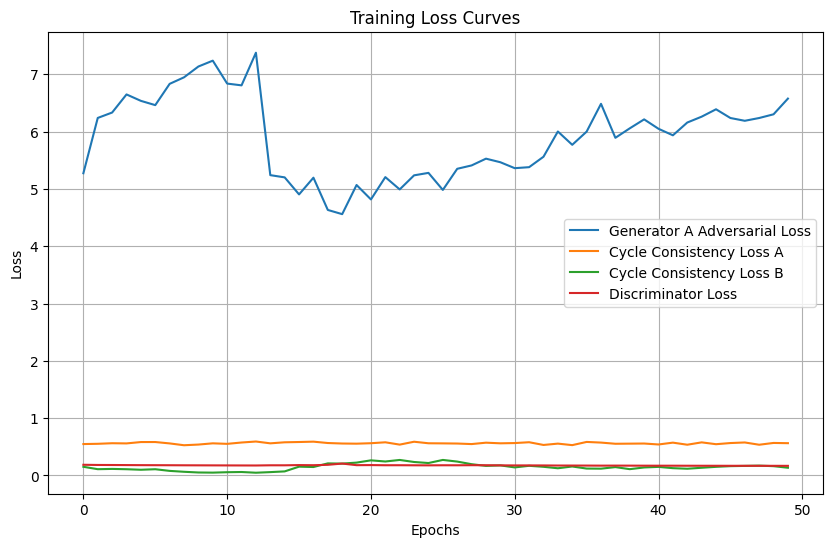

In [28]:
# plotting the loss curves
plt.figure(figsize=(10, 6))

plt.plot(losses["G_A"], label="Generator A Adversarial Loss")
plt.plot(losses["Cycle_A"], label="Cycle Consistency Loss A")
plt.plot(losses["Cycle_B"], label="Cycle Consistency Loss B")
plt.plot(losses["D"], label="Discriminator Loss")

plt.title("Training Loss Curves")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()